In [5]:
REPO = '../'
RESULT_TABLE = f'{REPO}/data/table'
RESULT_OBJ = f'{REPO}/data/object'
FIGURE_FOLDER= f'{REPO}/data/figure'
SETTING_FOLDER = f'{REPO}/data/setting'
EXTERNAL_DATA=f'{REPO}/data/external'
# load Terra API for get data table from Terra
import sys
sys.path.append(REPO)
from settings import COLOR_PAlETTE
from utils.visual import *

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scPipe as sp
import scanpy as sc
import seaborn as sns
import pickle
import warnings
import commentjson
### Additional Colormap
with open(f'{SETTING_FOLDER}/ColorMap.json','r') as f:
    colormap = commentjson.load(f)
COLOR_PAlETTE.update(colormap)
plt.style.use(f'{REPO}/paper.mplstyle')
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
anno = pd.read_csv(f'{RESULT_TABLE}/MPs/Tumor/MetaProgram_Annotation.csv')
with open(f'{RESULT_TABLE}/MPs/Tumor/MP_anno_map.pickle', "rb") as input_file:
    MP_anno_map= pickle.load(input_file)

with open(f'{RESULT_TABLE}/MPs/Tumor/MP_order_color.pickle', "rb") as input_file:
    MP_order_color = pickle.load(input_file)
    COLOR_PAlETTE['MetaProgram'] = MP_order_color['MP_Colors']
    del MP_order_color
    
MP_Genesets = pd.read_csv(f'{RESULT_TABLE}/MPs/Tumor//MP_Programs.gmt',sep='\t',header=None,index_col=0).iloc[:,1:].T

# Representative gene set  selection

In [11]:
anno['MPs'] = anno.MetaProgram.map(MP_anno_map)
anno['MPs'].value_counts().sort_index()

Apelin                  4
Cell_Cycle             24
EMT-I                  12
EMT-II                  6
EMT-III                 5
ER-I                    3
ER-II                   5
Interferon/MHCII(I)     7
Stress                  5
Name: MPs, dtype: int64

In [16]:
MP_Visual_Genes = {
    'MP2':["BRCA1","TOP2A","TPX2"],
    'MP3':["VIM","FN1","VCAN"],
    'MP4':['STAT1','TAP1','CXCL10'],
    'MP5':['CCN1','TIPARP','CCNL1'],
    'MP6':['TNFRSF12A','FLNA','PMEPA1'],
    'MP7':['GATA3','FUT8','RHOBTB3'],
    'MP8':['AR','PAPSS2','DHRS2'],
    'MP9':['GNGT1','MAP1B','NEGR1'],
    'MP11':['DST','PAM','XDH']
}

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


Text(0.5, 0.98, 'Metaprogram related function')

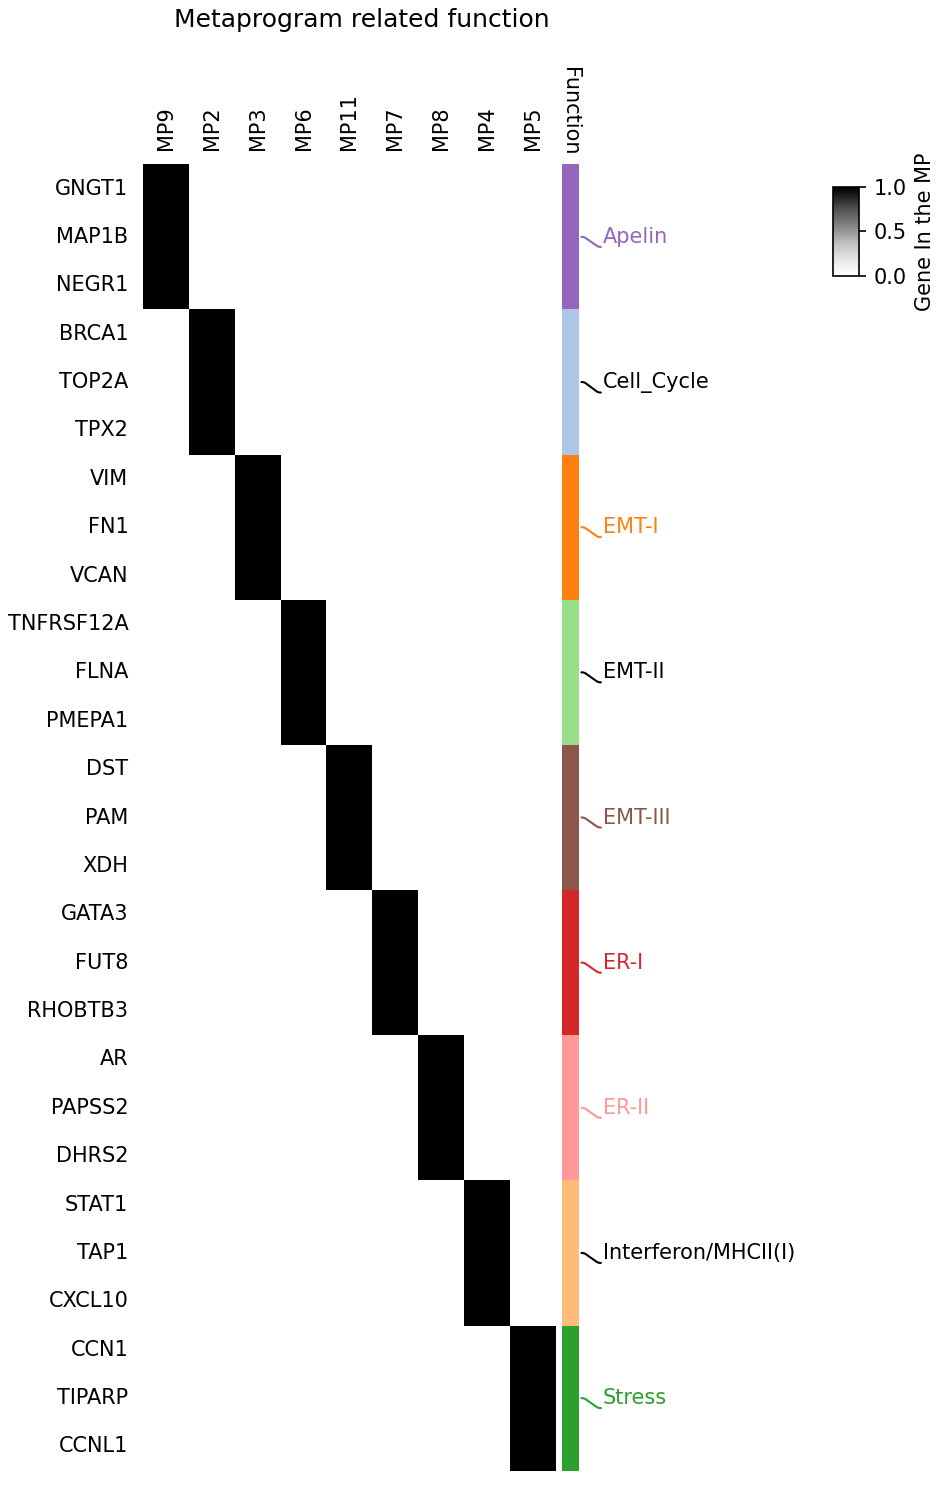

In [17]:
genes = pd.Series(np.vstack(MP_Visual_Genes.values()).flatten())
genes.index=genes
dt = MP_Genesets.apply(lambda c: genes.map(lambda x: x in c.values),axis=0).astype(int)
dt = dt.sort_values(dt.columns.tolist())

df_rows = pd.DataFrame(MP_Visual_Genes).unstack().reset_index().set_index(0)
colors = { MP_anno_map[k]:v for k,v in COLOR_PAlETTE['MetaProgram'].items() if k in df_rows['level_0'].unique()}
df_rows['MP'] = df_rows['level_0'].map(MP_anno_map)
df_rows = df_rows.sort_values('MP')
col_orders = df_rows['level_0'].unique().tolist()
dt = dt[col_orders].sort_values(col_orders,ascending=False)
df_rows = df_rows.loc[dt.index,:]

row_ha = HeatmapAnnotation(
    Function=anno_simple(df_rows['MP'],legend=False,
                           legend_kws=dict(frameon=False),
                           colors=colors),
     Anno=anno_label(df_rows['MP'],legend=False,
                          colors=colors,merge=True),
    verbose=0,axis=0,plot_legend=True)


plt.figure(figsize=(4, 10),dpi=150)
cm = ClusterMapPlotter(data=dt,
                       right_annotation=row_ha,
                       col_cluster=False,
                       row_cluster=False,
                       show_colnames=True,
                       show_rownames=True,
                       vmax=1,
                       vmin=0,
                       label='Gene In the MP',
                       cmap='Greys',rasterized=True,col_names_side='top')
plt.suptitle('Metaprogram related function')

# Cellstate annotation

In [19]:
scores_path = f'{RESULT_TABLE}/MPs/Tumor/signature_scores.csv'
# get MP sores on all cells 
scores = pd.read_csv(scores_path,index_col=0)
# select the signature scoring method
signature_method ='VISION'
scores = scores[scores.columns[scores.columns.str.endswith(signature_method)]]
scores.columns = scores.columns.map(lambda x:x.split('_')[0]).map(MP_anno_map)
scores

,Interferon/MHCII(I),Cell_Cycle,EMT-I,EMT-II,ER-I,Stress,ER-II,EMT-III,Apelin
CTCTAGCTCCGTGACA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,1.090037,0.949820,2.145981,3.018099,0.794341,1.037353,0.408186,3.653724,1.000169
AGCGATTTCTATTGTC-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,1.060983,0.626584,1.515372,2.763045,0.393587,1.150732,0.385483,4.298751,1.010139
GTGCACGGTATACTGG-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,1.073133,0.663292,1.910368,2.951624,0.444976,0.661144,0.780612,5.705826,1.217294
TCCACAACACATGCTA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,0.857328,1.072945,2.037957,2.306717,1.710290,0.618504,0.975268,4.251299,1.039251
ATGAATGCATCCGTAA-1_CCG1112_16_T4_A1_CCG1112_MO_Batch1,0.494133,0.697514,0.470433,1.887798,4.242550,0.613716,2.363956,0.894916,1.613358
...,...,...,...,...,...,...,...,...,...
CATCGAATCGACAGCC-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,-0.008954,-0.139214,0.121305,0.157290,0.889248,-0.008954,1.236874,0.605775,0.382585
ACTGCTCTCATTCACT-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,0.165385,-0.137984,0.232815,0.263333,0.934408,-0.004212,0.964501,-0.004212,0.336198
GAACATCGTAAGAGGA-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,0.230335,0.194561,0.335789,0.356510,0.467864,0.921693,0.412868,2.141814,0.427240
CATCAAGGTCTGGAGA-1_CCG1112_13_T3_A1_SN_5GEX_CCG1112_snRNA_Batch1,-0.122859,0.028272,-0.122859,0.028272,0.217461,0.028272,0.771196,0.269311,0.888727


## GMM assignment

In [20]:
from signaturescoring.scoring_methods.gmm_postprocessing import GMMPostprocessor
import anndata
tumor = anndata.AnnData(obs=scores)
# initialize GMMPostprocessor
gmm_post = GMMPostprocessor(
    n_components=scores.shape[1]
)
# fit the GMM model on the 3 columns of the scores
features_name = scores.columns.tolist()
store_name_pred, store_names_proba, _ = gmm_post.fit_and_predict(tumor,features_name )

# assign clusters to signatures
assignments = gmm_post.assign_clusters_to_signatures(tumor,features_name, store_names_proba, plot=False)
scoring_names_gmm = []
for key, val in assignments.items():
    if key =='rest':
        continue
    tumor.obs[key+'_gmm'] = tumor.obs[val].copy()
    scoring_names_gmm.append(key+'_gmm')

In [22]:
pd.Series(assignments).iloc[:-1].sort_values()

ER-II                  1_GMM_proba
Interferon/MHCII(I)    4_GMM_proba
EMT-I                  4_GMM_proba
Cell_Cycle             5_GMM_proba
ER-I                   6_GMM_proba
Apelin                 6_GMM_proba
EMT-III                7_GMM_proba
EMT-II                 8_GMM_proba
Stress                 8_GMM_proba
dtype: object

## Explore the correlation between MPs

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 30.516666666666666 mm


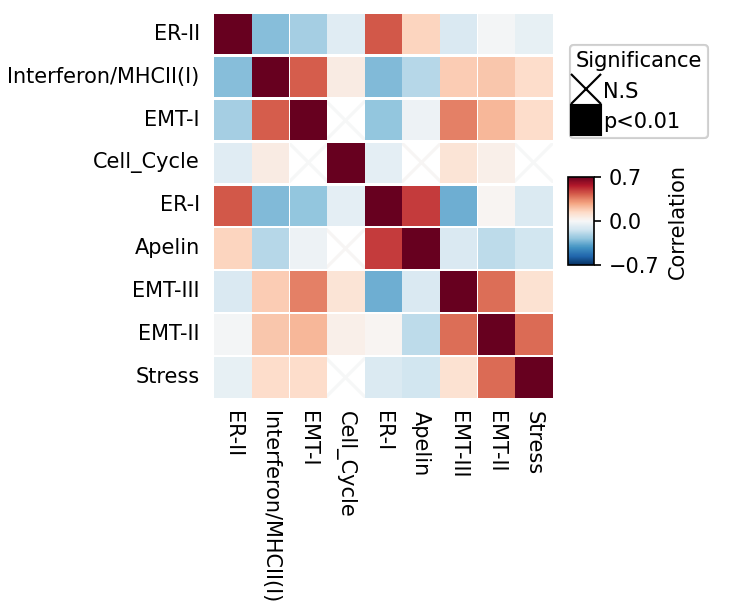

In [23]:
dt =  scores.copy()
order = pd.Series(assignments).iloc[:-1].sort_values().index.tolist()
pvalues = []
for c in dt:
    p = dt.apply(lambda a: scipy.stats.pearsonr(a.values,dt[c].values)[1])
    p.name= c
    pvalues.append(p)
pvalues = pd.concat(pvalues,axis=1)
corr =  dt.corr()

data = corr.unstack().rename('Correlation').to_frame()
data['pvalue'] = pvalues.unstack()
data['Significance'] = 'N.S'
data.loc[data['pvalue']<0.01,'Significance'] = 'p<0.01'

data = data.reset_index()#.drop_duplicates(['pvalue','Correlation'])
# data = data.loc[data.level_0!=data.level_1,:]

plt.figure(figsize=(3, 3),dpi=150)


# col_ha = HeatmapAnnotation(label=anno_label(pd.Series(['Endocytosis','Lipid','Presentation','Interferon','Adhesion','Secretion'])))
cm = DotClustermapPlotter(data=data, x='level_0',y='level_1',value='Correlation',c='Correlation',hue='Significance',
                          s=4,
                          col_split=pd.Series(order,index=order),
                          col_split_order = order,
                          row_split=pd.Series(order,index=order),
                          row_split_order = order,
                          marker={'N.S':'x','p<0.01':'s'},
                          vmax=.7,vmin=-.7,cmap='RdBu_r',
                          ratio=200,
                          row_cluster=False,col_cluster=False,
                          show_rownames=True,show_colnames=True,row_names_side='left')
plt.show()

In [24]:
curr_val= tumor.obs[scoring_names_gmm].idxmax(axis="columns")
cellstate= curr_val.map(lambda x:'Tumor.'+x.replace('_gmm','')).rename('Cellstate').to_frame()
cellstate.to_csv(f'{RESULT_TABLE}/MPs/Tumor/Annotation.csv')

In [27]:
adata = sc.read(f'{RESULT_OBJ}/gex_tumor.h5ad')
obs_path = f'{RESULT_TABLE}/GEX_OBS.csv'
obs = pd.read_csv(obs_path,index_col=0)
# cross sanity check
for c in ['Cellstate','BestResponse','Patient','Timepoint','Sample_Short','Treatment_Arm','RCB']:
    adata.obs[c] = obs.loc[adata.obs.index,c]
pd.crosstab(adata.obs.loc[cellstate.index,'Cellstate'],cellstate['Cellstate'])

Cellstate,Tumor.Cell_Cycle,Tumor.EMT-II,Tumor.EMT-III,Tumor.ER-I,Tumor.ER-II,Tumor.Interferon/MHCII(I)
Cellstate,,,,,,
Tumor.Cell_Cycle,13885,0,0,0,0,0
Tumor.EMT-II,0,5441,0,0,0,0
Tumor.EMT-III,0,0,2704,0,0,0
Tumor.ER-I,0,0,0,30197,0,0
Tumor.ER-II,0,0,0,0,9833,0
Tumor.Interferon/MHCII(I),0,0,0,0,0,3146


In [28]:
adata.obs['Cellstate']= cellstate['Cellstate']

# MP marker visualization

In [29]:
sp.utils.log1pNorm(adata)

In [30]:
MP_Genesets.columns = MP_Genesets.columns.map(MP_anno_map)
MP_Genesets=MP_Genesets.melt()
MP_Genesets.columns = ['Program','gene']
MP_Genesets = MP_Genesets.drop_duplicates(subset=['gene'],keep=False).set_index('gene')

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 19.051388888888887 mm


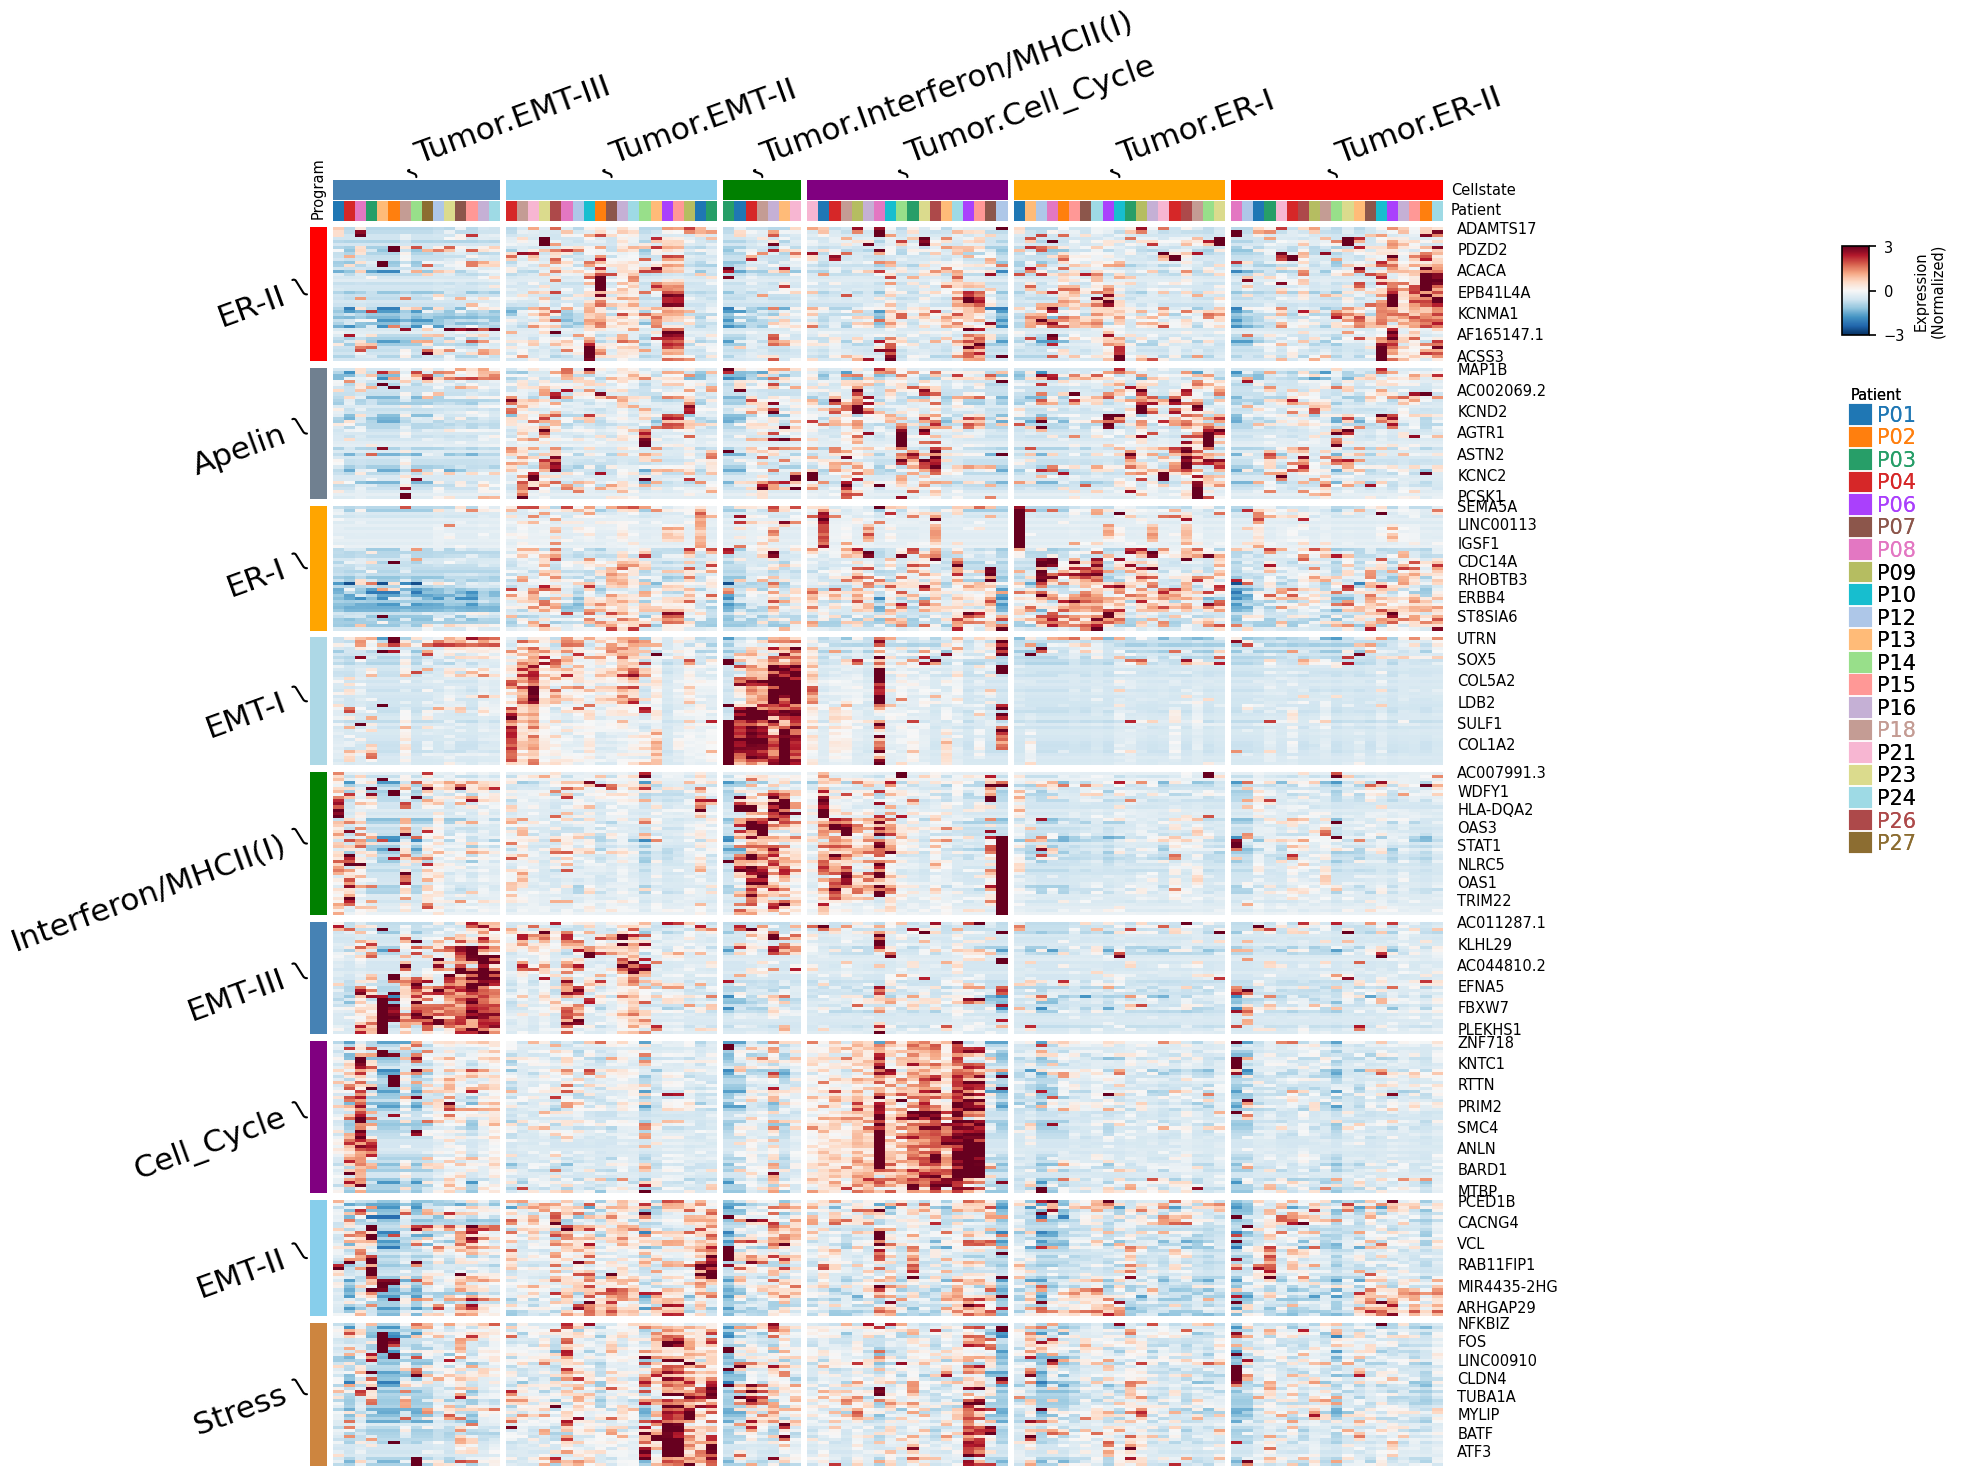

In [34]:
palette={}
palette['Program'] = {k.replace('Tumor.',''):v for k,v in COLOR_PAlETTE['Cellstate'].items() if 'Tumor' in k}
for c in ['BestResponse','Patient','Timepoint','Cellstate']:
    palette[c] = COLOR_PAlETTE[c]
aggregate_heatmap(adata=adata,
                  features=MP_Genesets,
                  top_anno_columns=['Cellstate','Patient'],
                  col_split='Cellstate',
                  col_split_gap=1,
                  row_split='Program',
                  row_split_gap=1,
                  palette=palette,
                  figsize=(10,10),
                  vmin=-3,
                  vmax=3,
                  standard_normalization=True,
                  cbar_label='Expression\n(Normalized)',
                  cmap='RdBu_r'
                 )